### Analysis

In [1]:
import warnings
warnings.filterwarnings('ignore')
from DeepTCR.DeepTCR import DeepTCR_U

In [2]:

# Instantiate training object
DTCRU = DeepTCR_U('TCR_Analysis')

# Path to your dataset
data_directory = r"E:\Python code\Machine learning\JupyterNote\Bio\deepTCR\DeepTCR_input"

# Load Data from CNS & Spleen directories
DTCRU.Get_Data(directory=data_directory, Load_Prev_Data=False, aggregate_by_aa=True,
               aa_column_beta=0, count_column=1, v_beta_column=2, j_beta_column=3)

print("Data loaded successfully into DeepTCR!")


Loading Data...
Embedding Sequences...
Data Loaded
Data loaded successfully into DeepTCR!


In [3]:
# Train Variational Autoencoder (VAE) with adjusted parameters
DTCRU.Train_VAE(
    latent_dim=96,          # Reduce latent dimension to prevent overfitting on 20K sequences
    batch_size=5000,         # Reduce batch size to prevent memory overload
    epochs_min=5,            # Ensure at least 5 training epochs
    stop_criterion_window=30, # Increase patience for stopping
    learning_rate=0.001,    # Slightly slower learning rate for better stability
    Load_Prev_Data=False     # Ensure fresh training
)

print("DeepTCR VAE training completed!")


Epoch = 0, Iteration = 0 Total Loss: 7.27330: Recon Loss: 7.24227: Latent Loss: 0.03103: Sparsity Loss: 0.00000: Recon Accuracy: 0.03896
Epoch = 0, Iteration = 1 Total Loss: 7.01036: Recon Loss: 6.97944: Latent Loss: 0.03091: Sparsity Loss: 0.00000: Recon Accuracy: 0.05360
Epoch = 0, Iteration = 2 Total Loss: 6.85726: Recon Loss: 6.82513: Latent Loss: 0.03213: Sparsity Loss: 0.00000: Recon Accuracy: 0.07349
Epoch = 0, Iteration = 3 Total Loss: 6.74897: Recon Loss: 6.71381: Latent Loss: 0.03515: Sparsity Loss: 0.00000: Recon Accuracy: 0.09465
Epoch = 0, Iteration = 4 Total Loss: 6.67227: Recon Loss: 6.63349: Latent Loss: 0.03879: Sparsity Loss: 0.00000: Recon Accuracy: 0.11796
Epoch = 0, Iteration = 5 Total Loss: 6.59305: Recon Loss: 6.55235: Latent Loss: 0.04070: Sparsity Loss: 0.00000: Recon Accuracy: 0.13893
Epoch = 0, Iteration = 6 Total Loss: 6.52231: Recon Loss: 6.48207: Latent Loss: 0.04024: Sparsity Loss: 0.00000: Recon Accuracy: 0.15307
Epoch = 1, Iteration = 0 Total Loss: 6.44

In [4]:
import pandas as pd

def extract_features_from_DTCRU(DTCRU):
    """
    Extracts latent features along with CDR3 sequences, V-beta, J-beta, and labels into a DataFrame.

    Args:
        DTCRU: The feature_analytics_class instance.

    Returns:
        Pandas DataFrame containing:
        - Features (latent embeddings)
        - CDR3 Beta Sequences
        - V_beta, J_beta
        - Labels (Sample/Cluster ID)
    """

    # Convert latent features to DataFrame
    feature_df = pd.DataFrame(DTCRU.features)

    # Convert sequence data to DataFrame
    metadata_df = pd.DataFrame({
        "CDR3_Beta": DTCRU.beta_sequences,
        "V_Beta": DTCRU.v_beta,
        "J_Beta": DTCRU.j_beta,
        "Label": DTCRU.sample_id  # Use sample_id as labels
    })

    # Merge latent features with metadata
    full_df = pd.concat([metadata_df, feature_df], axis=1)

    return full_df

# Usage:
features_df = extract_features_from_DTCRU(DTCRU)

# Save to CSV if needed
features_df.to_csv("DTCRU_extracted_features_96.csv", index=False)

#features_df 

# Saved embs

In [53]:
# # Reduce clusters by lowering PhenoGraph resolution (t)
# DTCRU.Cluster(
#     clustering_method='phenograph',  # Keep PhenoGraph clustering
#     t=5,                     # Lower resolution (default ~30); reduce for fewer clusters
#     n_jobs=4                 # Use multiple threads for efficiency
# )
DTCRU.Cluster(
    set='all', 
    clustering_method='dbscan',  # Use DBSCAN
    t=6,  # Higher values merge clusters (default is auto-tuned)
    n_jobs=4
)

Clustering Done


In [54]:
DFs = DTCRU.Cluster_DFs
len(DFs)

117

In [55]:
print(DFs[2])

      index Alpha_Sequences    Beta_Sequences V_alpha J_alpha  \
0         2            None        CASGEDTQYF    None    None   
1         3            None    CASGEPGGQNTLYF    None    None   
2         7            None   CASGETGGNYAEQFF    None    None   
3        20            None   CASGDETGGYAEQFF    None    None   
4        24            None    CASGERDRDSDYTF    None    None   
...     ...             ...               ...     ...     ...   
2986  27434            None  CASGEGTGGSQNTLYF    None    None   
2987  27435            None  CASGEGTGGIQNTLYF    None    None   
2988  27436            None    CASGEGTGGAEQFF    None    None   
2989  30887            None       CASSGDDTQYF    None    None   
2990  30953            None  CASSGGLGGSQNTLYF    None    None   

                 V_beta D_beta   J_beta  Frequency  Labels  \
0     TRBV12-2+TRBV13-2   None  TRBJ2-5   0.015730     CNS   
1     TRBV12-2+TRBV13-2   None  TRBJ2-4   0.012683     CNS   
2     TRBV12-2+TRBV13-2   None  T

In [8]:
# import matplotlib.pyplot as plt

# # Initialize lists to store cluster indices and weighted CNS proportions
# cluster_ids = []
# cns_proportions = []

# # Iterate through clusters and compute weighted CNS proportions
# for i, df in enumerate(DFs):
#     total_freq = df["Frequency"].sum()  # Sum of frequencies in cluster
#     cns_freq = df.loc[df["Labels"] == "CNS", "Frequency"].sum()  # Sum of CNS frequencies
    
#     # Avoid division by zero
#     cns_ratio = cns_freq #/ total_freq if total_freq > 0 else 0
    
#     cluster_ids.append(i + 1)  # Cluster numbers start from 1
#     cns_proportions.append(cns_ratio)

# # Plot CNS proportion per cluster
# plt.figure(figsize=(12, 6))
# plt.bar(cluster_ids, cns_proportions, color="dodgerblue")

# plt.xlabel("Cluster")
# plt.ylabel("CNS Proportion (Weighted by Frequency)")
# plt.title("Weighted Proportion of CNS Sequences in Each Cluster")
# #plt.ylim(0, 1)  # Set proportion range between 0 and 1
# plt.xticks(rotation=90)  # Rotate x-axis labels if needed
# plt.show()
# import matplotlib.pyplot as plt

# # Initialize lists to store cluster indices and weighted CNS proportions
# cluster_ids = []
# cns_proportions = []

# # Iterate through clusters and compute weighted CNS proportions
# for i, df in enumerate(DFs):
#     total_freq = df["Frequency"].sum()  # Sum of frequencies in cluster
#     cns_freq = df.loc[df["Labels"] == "Spleen", "Frequency"].sum()  # Sum of CNS frequencies
    
#     # Avoid division by zero
#     cns_ratio = cns_freq #/ total_freq if total_freq > 0 else 0
    
#     cluster_ids.append(i + 1)  # Cluster numbers start from 1
#     cns_proportions.append(cns_ratio)

# # Plot CNS proportion per cluster
# plt.figure(figsize=(12, 6))
# plt.bar(cluster_ids, cns_proportions, color="dodgerblue")

# plt.xlabel("Cluster")
# plt.ylabel("Spleen Proportion (Weighted by Frequency)")
# plt.title("Weighted Proportion of CNS Sequences in Each Cluster")
# #plt.ylim(0, 1)  # Set proportion range between 0 and 1
# plt.xticks(rotation=90)  # Rotate x-axis labels if needed
# plt.show()

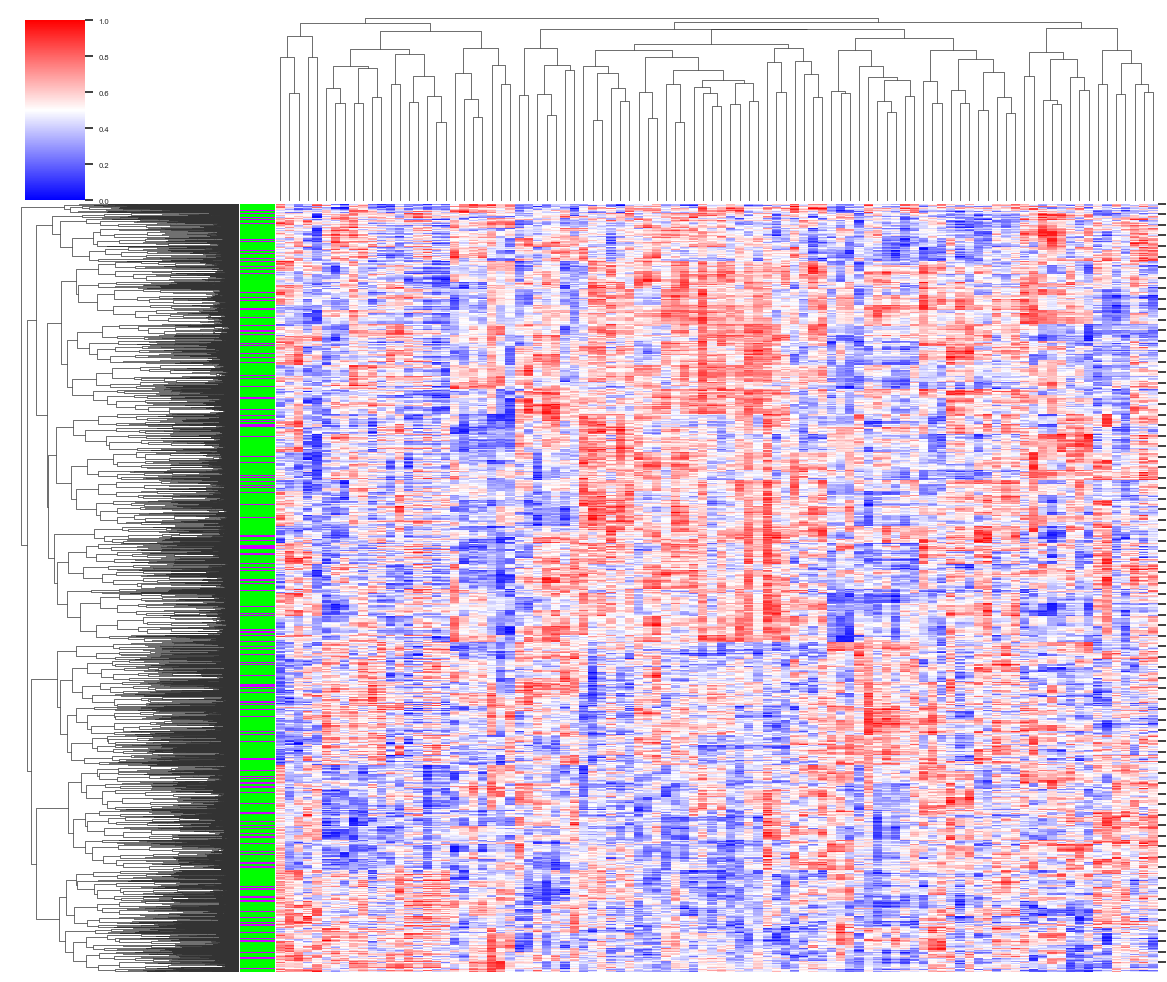

<Figure size 640x480 with 0 Axes>

In [9]:
DTCRU.HeatMap_Sequences()

In [50]:
DTCRU.Structural_Diversity()

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 6.561381578445435 seconds
Jaccard graph constructed in 17.66869330406189 seconds
Wrote graph to binary file in 0.5732829570770264 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.995903
Louvain completed 21 runs in 6.100107669830322 seconds
PhenoGraph complete in 31.084426879882812 seconds


In [56]:
DTCRU.Structural_Diversity_DF

,Sample,Class,Entropy,Num of Clusters
0,E:\Python code\Machine learning\JupyterNote\Bi...,CNS,5.520969,394
1,E:\Python code\Machine learning\JupyterNote\Bi...,Spleen,5.870729,394


In [12]:
# Extract normalized frequency and sample IDs from DeepTCR
import numpy as np

normalized_freq = np.array(DTCRU.freq)  # Already normalized per sample
sample_ids = np.array(DTCRU.sample_id)

# Count the number of sequences in CNS and Spleen
num_cns = np.sum(sample_ids == "CNS.tsv")
num_spleen = np.sum(sample_ids == "Spleen.tsv")

# Compute rescaling factor: adjust Spleen frequencies to match CNS scale
scale_factor = num_spleen / num_cns

# Rescale the Spleen frequencies only
adjusted_freq = np.where(sample_ids == "Spleen.tsv", normalized_freq * scale_factor, normalized_freq)
DTCRU.freq = adjusted_freq

In [13]:
DTCRU.freq

array([2.57398657e-02, 1.89007710e-02, 1.57299179e-02, ...,
       2.87860906e-05, 2.87860906e-05, 2.87860906e-05])

In [14]:
scale_factor

nan

In [15]:
num_cns

0

In [16]:
num_spleen

0

In [17]:
DTCRU.freq

array([2.57398657e-02, 1.89007710e-02, 1.57299179e-02, ...,
       2.87860906e-05, 2.87860906e-05, 2.87860906e-05])

In [18]:
DTCRU.UMAP_Plot(Load_Prev_Data=True,by_sample=True, show_legend=True,freq_weight=True,scale=10000) #by_cluster=True,by_cluster=True,freq_weight=True

FileNotFoundError: [Errno 2] No such file or directory: 'TCR_Analysis\\umap.pkl'

In [ ]:
DTCRU.UMAP_Plot(Load_Prev_Data=True,by_cluster=True, show_legend=False,freq_weight=True,scale=5000)

### Comparison between GIANA embeddings and DeepTCR embeddings

In [61]:
import pandas as pd

In [63]:
DTCRU_features_df = pd.read_csv(r"E:\Python code\Machine learning\JupyterNote\Bio\deepTCR\DTCRU_extracted_features_96.csv")

In [64]:
DTCRU_features_df

,CDR3_Beta,V_Beta,J_Beta,Label,0,1,2,3,4,5,...,86,87,88,89,90,91,92,93,94,95
0,CTCSADPGVNQDTQYF,TRBV1,TRBJ2-5,E:\Python code\Machine learning\JupyterNote\Bi...,1.161676,2.927206,-1.003227,0.117915,0.432241,-2.408952,...,0.135233,-0.282872,0.211147,1.719347,0.238718,0.709447,0.713822,-0.437790,0.887293,0.500020
1,CASSQDGDSDYTF,TRBV5,TRBJ1-2,E:\Python code\Machine learning\JupyterNote\Bi...,3.009606,-1.118266,-0.948345,0.222866,-1.597997,-0.307781,...,1.903245,-0.797055,-0.124508,-1.308144,1.902324,-0.479415,-0.816657,0.437461,0.020691,0.455438
2,CASGEDTQYF,TRBV12-2+TRBV13-2,TRBJ2-5,E:\Python code\Machine learning\JupyterNote\Bi...,2.515276,-0.170478,-0.080706,-0.566822,1.273288,0.391690,...,0.049784,-0.917020,1.260049,-0.735452,0.824629,-0.474364,-0.025572,1.366963,0.665590,0.782371
3,CASGEPGGQNTLYF,TRBV12-2+TRBV13-2,TRBJ2-4,E:\Python code\Machine learning\JupyterNote\Bi...,-0.890202,0.242895,3.120327,-1.365069,-0.755155,1.171127,...,-0.787602,-0.738088,0.582221,-0.393441,0.163469,-0.090892,1.123530,0.198518,-0.165764,-0.109233
4,CASSLELGAETLYF,TRBV16,TRBJ2-3,E:\Python code\Machine learning\JupyterNote\Bi...,-1.068649,-0.773972,0.176088,1.487289,-1.832417,-0.067876,...,-0.081930,1.646871,-0.650085,0.366735,-0.618225,0.037214,-0.529054,-0.118142,-0.666613,-0.595111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33764,CASSIRQGQNTLYF,TRBV19,TRBJ2-4,E:\Python code\Machine learning\JupyterNote\Bi...,-1.686158,-0.262847,2.236134,-0.184740,-1.567291,0.319895,...,-0.150306,-0.344077,-0.654730,-0.041485,0.099386,0.733494,0.676026,0.077808,-0.435473,-0.840315
33765,CASSIRQGNSDYTF,TRBV19,TRBJ1-2,E:\Python code\Machine learning\JupyterNote\Bi...,1.936375,-0.899403,-1.147632,1.689945,-2.685961,-1.630017,...,1.194741,-0.330712,-0.328270,-0.102522,1.135355,0.937442,-0.761925,0.768749,0.916292,0.480147
33766,CASSIRQGGTGQLYF,TRBV13-1,TRBJ2-2,E:\Python code\Machine learning\JupyterNote\Bi...,-1.992948,2.131273,1.595339,-1.411866,1.768814,1.189515,...,-0.396655,1.087217,0.208567,0.344291,0.488986,-0.202582,0.505803,-0.539269,-0.451445,-0.430040
33767,CASSIRQGGTEVFF,TRBV19,TRBJ1-1,E:\Python code\Machine learning\JupyterNote\Bi...,1.265220,0.872827,0.237077,-0.843855,-2.335339,-0.406186,...,0.098149,-0.720009,-1.525614,0.005775,0.353821,1.444805,0.470818,0.101059,0.031765,0.195848


In [119]:
# File paths
embedding_path = r"E:\Python code\Machine learning\JupyterNote\Bio\GIANA\LEE_data\cdr3_only\cdr3_id--RotationEncodingBL62_EncodingMatrix_CFadded.txt"

# Load GIANA embeddings
GIANA_features_df = pd.read_csv(embedding_path, sep="\t", header=None)
GIANA_features_df = GIANA_features_df.iloc[:,1:]
GIANA_features_df = GIANA_features_df.drop(columns=GIANA_features_df.columns[1])
GIANA_features_df = GIANA_features_df.rename(columns={1: 0})
GIANA_features_df

,0,3,4,5,6,7,8,9,10,11,...,89,90,91,92,93,94,95,96,97,98
0,CAAAGGQNTLYF,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.534093,0.548508,0.594903,0.326693,-0.453553,-0.563170,-0.554163,0.181178,-0.716009,-0.089898
1,CAAGHPNERLFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.775529,-0.107204,0.552521,-0.343972,-0.598137,0.155677,0.030710,-0.021761,0.344427,0.146815
2,CAAGTENTEVFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.375285,-0.414794,-0.193253,0.547322,-0.118765,0.328440,-0.259283,0.595001,0.351684,-0.217337
3,CAARGPNTEVFF,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.534093,0.548508,0.594903,0.326693,-0.453553,-0.563170,-0.554163,0.181178,-0.716009,-0.089898
4,CAARGTNSDYTF,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.534093,0.548508,0.594903,0.326693,-0.453553,-0.563170,-0.554163,0.181178,-0.716009,-0.089898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40952,CAWSPQLLRDRGSQNTLYF,1.237117,0.030060,0.620989,-0.536772,-0.551788,0.320186,0.194937,1.201312,-0.155492,...,0.068103,0.518609,0.998522,0.206911,-0.751928,-0.865498,-0.921544,0.043199,-0.672380,0.245639
40953,CTCSADRDWGGLNQDTQYF,-0.642721,-0.974322,-0.570437,-0.165921,-1.061089,-0.170762,0.561932,0.574888,0.177300,...,-0.553465,-0.347591,-0.652497,-0.572012,0.312651,-0.119563,0.465160,-0.030441,-0.719839,0.737519
40954,CTCSAPRGGTGGGQDTQYF,-0.642721,-0.974322,-0.570437,-0.165921,-1.061089,-0.170762,0.561932,0.574888,0.177300,...,1.221860,1.126777,0.535163,0.207328,-0.574577,-0.784084,-0.119884,0.895657,-0.388549,-0.055234
40955,CASSWTGSSAETLYFGSGTYEQYF,-0.642721,-0.974322,-0.570437,-0.165921,-1.061089,-0.170762,0.561932,0.574888,0.177300,...,0.169664,-0.345310,0.684655,0.227345,-0.214995,0.212352,-0.244805,0.575452,-0.230508,0.575113


In [89]:
# for i in range(len(GIANA_features_df)):
#     GIANA_features_df.iloc[i,0] = "C" + GIANA_features_df.iloc[i,0] + "F"

# GIANA_features_df.to_csv('cdr3_id--RotationEncodingBL62_EncodingMatrix_CFadded.csv', header = None, sep="\t")

In [107]:
import numpy as np
DTCRU_features_df = DTCRU_features_df.iloc[:, np.r_[0, 4:DTCRU_features_df.shape[1]]]
# GIANA_features_df = GIANA_features_df.iloc[:, np.r_[0, 2:GIANA_features_df.shape[1]]]

In [122]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform

# Step 1: Ensure unique CDR3_Beta sequences by averaging embeddings if duplicated
DTCRU_unique = DTCRU_features_df.groupby("CDR3_Beta").mean().reset_index()
GIANA_unique = GIANA_features_df.groupby(0).mean().reset_index()  # Column 0 contains CDR3_Beta in GIANA

# Step 2: Find the common CDR3 sequences among all three datasets
common_cdr3 = set(DTCRU_unique["CDR3_Beta"]).intersection(GIANA_unique[0])

# Step 3: Keep only common sequences and sort them
DTCRU_matched = DTCRU_unique[DTCRU_unique["CDR3_Beta"].isin(common_cdr3)].sort_values("CDR3_Beta").reset_index(drop=True)
GIANA_matched = GIANA_unique[GIANA_unique[0].isin(common_cdr3)].sort_values(by=0).reset_index(drop=True)

# Step 4: Extract embeddings
DTCRU_embeddings = DTCRU_matched.iloc[:, 1:].values  # Exclude CDR3_Beta (first column)
GIANA_embeddings = GIANA_matched.iloc[:, 1:].values  # Exclude CDR3_Beta (first column)

# Step 5: Compute pairwise distances within each embedding space
DTCRU_distances = squareform(pdist(DTCRU_embeddings, metric="euclidean"))
GIANA_distances = squareform(pdist(GIANA_embeddings, metric="euclidean"))

# Step 6: Flatten upper triangle of the distance matrices for correlation analysis
DTCRU_distances_flat = DTCRU_distances[np.triu_indices_from(DTCRU_distances, k=1)]
GIANA_distances_flat = GIANA_distances[np.triu_indices_from(GIANA_distances, k=1)]



In [123]:
import numpy as np
from scipy.stats import spearmanr

# Randomly subsample 100,000 pairs for faster correlation
sample_size = min(100000, len(DTCRU_distances_flat))  # Adjust sample size if needed
indices = np.random.choice(len(DTCRU_distances_flat), size=sample_size, replace=False)

# Compute Spearman on subsampled data
spearman_DG, p_DG = spearmanr(DTCRU_distances_flat[indices], GIANA_distances_flat[indices])

results = pd.DataFrame({
    "Comparison": ["DTCRU vs GIANA"],
    "Spearman Correlation": [spearman_DG],
    "p-value": [p_DG]
})
results 

,Comparison,Spearman Correlation,p-value
0,DTCRU vs GIANA,0.157296,0.0


In [124]:
DTCRU_features_df.shape

(33769, 91)

In [125]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_completeness_v_measure
import pandas as pd

# Perform K-Means clustering for all three datasets
DTCRU_clusters = KMeans(n_clusters=10, random_state=1, n_init=10).fit_predict(DTCRU_embeddings)
GIANA_clusters = KMeans(n_clusters=10, random_state=1, n_init=10).fit_predict(GIANA_embeddings)

# Compute clustering similarity scores for all pairs
ari_DG = adjusted_rand_score(DTCRU_clusters, GIANA_clusters)  # DTCRU vs GIANA

nmi_DG = normalized_mutual_info_score(DTCRU_clusters, GIANA_clusters)

hom_DG, comp_DG, v_DG = homogeneity_completeness_v_measure(DTCRU_clusters, GIANA_clusters)

# Organize results in a DataFrame
clustering_results = pd.DataFrame({
    "Comparison": ["DTCRU vs GIANA"],
    "ARI": [ari_DG],
    "NMI": [nmi_DG],
    "Homogeneity": [hom_DG],
    "Completeness": [comp_DG],
    "V-Measure": [v_DG]
})

clustering_results


,Comparison,ARI,NMI,Homogeneity,Completeness,V-Measure
0,DTCRU vs GIANA,0.235334,0.371694,0.369823,0.373584,0.371694


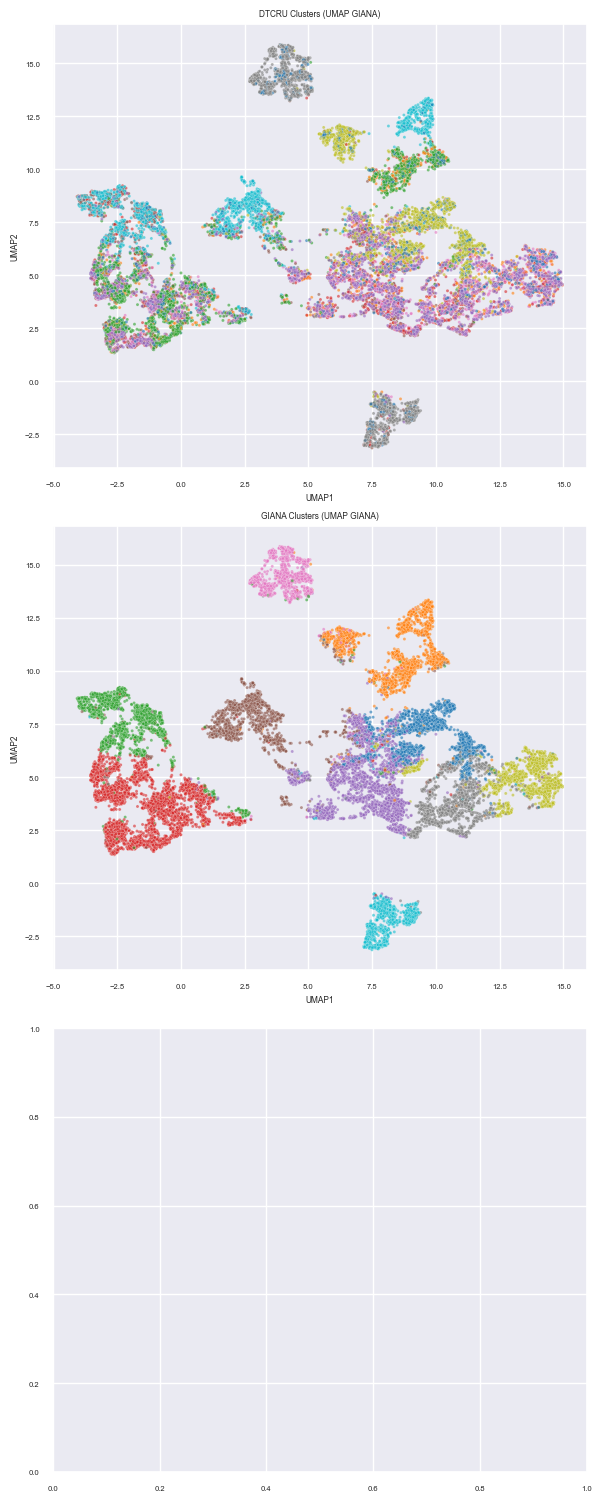

In [126]:
import umap
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Reduce dimensionality using only GIANA embeddings
umap_giana = umap.UMAP(n_components=2).fit_transform(GIANA_embeddings)

# Create dataframe for UMAP representation
df_umap = pd.DataFrame(umap_giana, columns=["UMAP1", "UMAP2"])
df_umap["DTCRU_Cluster"] = pd.Categorical(DTCRU_clusters)  # DTCRU clusters
df_umap["GIANA_Cluster"] = pd.Categorical(GIANA_clusters)  # GIANA clusters

# Set up a 3x1 subplot (3 plots)
fig, axes = plt.subplots(2, 1, figsize=(6, 15))
titles = ["DTCRU Clusters (UMAP GIANA)", "GIANA Clusters (UMAP GIANA)"]

# Define color palettes
dtcru_palette = sns.color_palette("tab10", len(df_umap["DTCRU_Cluster"].unique()))
giana_palette = sns.color_palette("tab10", len(df_umap["GIANA_Cluster"].unique()))

# Plot 1: DTCRU Clusters using GIANA UMAP
sns.scatterplot(data=df_umap, x="UMAP1", y="UMAP2", hue="DTCRU_Cluster", palette=dtcru_palette, alpha=0.6, s=5, ax=axes[0])
axes[0].set_title(titles[0])
axes[0].legend_.remove()

# Plot 2: GIANA Clusters using GIANA UMAP
sns.scatterplot(data=df_umap, x="UMAP1", y="UMAP2", hue="GIANA_Cluster", palette=giana_palette, alpha=0.6, s=5, ax=axes[1])
axes[1].set_title(titles[1])
axes[1].legend_.remove()

plt.tight_layout()
plt.show()



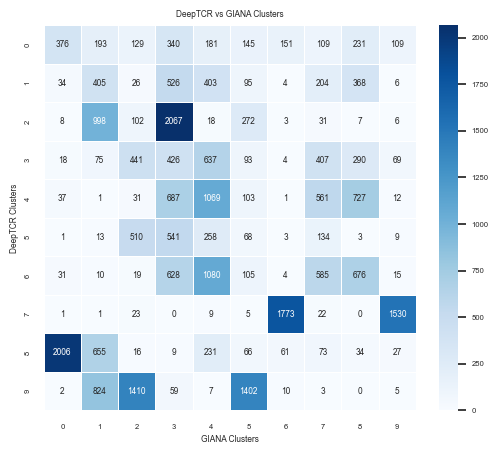

In [127]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create pairwise contingency tables
contingency_DG = pd.crosstab(DTCRU_clusters, GIANA_clusters)

# Function to plot heatmap
def plot_heatmap(contingency_table, xlabel, ylabel, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(contingency_table, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

# Plot each heatmap
plot_heatmap(contingency_DG, "GIANA Clusters", "DeepTCR Clusters", "DeepTCR vs GIANA Clusters")
